# Challenge classification of bearing

In [23]:
# Import libraries

#Data analysis libraries
import numpy as np 
import pandas as pd 

#Visulization and statistics libraries
import matplotlib.pyplot as plt
from matplotlib.pyplot import style
from scipy import fftpack
import seaborn as sns
style.use('seaborn')

# Model preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

# Medel related libraries
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Setting to display all columns
pd.set_option("Display.max_columns", None)

In [3]:
#To load the data 
target_set = pd.read_csv("assets/bearing_classes.csv", sep=";", skipinitialspace=True)
origin_set = pd.read_csv("assets/bearing_signals.csv", skipinitialspace=True)

### Feature engineering

In [4]:
# To rename the column name using function
"""This function takes dataframe & prefix of the columns.
   It needs name of columns from the dataframe and add prefix before the each name of the columns.
   It returns dataframe with new column names."""
def rename_column(df,prefix):
    column_name = list(df.columns)
    column_name = [prefix + name for name in column_name]
    return df.set_axis(column_name, axis=1)

In [5]:
# To drop some columns from the dataframe
df_train = origin_set.drop(['experiment_id','bearing_1_id', 'timestamp'], axis=1)

In [6]:
# To see the column name of the dataframe
df_train.columns

Index(['bearing_2_id', 'a1_x', 'a1_y', 'a1_z', 'a2_x', 'a2_y', 'a2_z', 'rpm',
       'hz', 'w'],
      dtype='object')

In [7]:
# To find maximun, minimum, mean, standerd deviation, median, range, kurtosis and skewness
# of the data and apply function for rename the column names for each features
max_set = df_train.groupby(['bearing_2_id']).max()
max_set = rename_column(max_set,"max_")
min_set = df_train.groupby(['bearing_2_id']).min()
min_set = rename_column(min_set,"min_")
mean_set = df_train.groupby(['bearing_2_id']).mean()
mean_set = rename_column(mean_set,"mean_")
std_set = df_train.groupby(['bearing_2_id']).std()
std_set = rename_column(std_set,"std_")
median_set = df_train.groupby(['bearing_2_id']).median()
median_set = rename_column(median_set,"median_")
range_set = df_train.groupby(['bearing_2_id']).max() - df_train.groupby(['bearing_2_id']).min()
range_set = rename_column(range_set,"range_")
kurtosis_set = df_train.groupby(['bearing_2_id']).apply(pd.DataFrame.kurtosis)
kurtosis_set = rename_column(kurtosis_set, 'kurtosis_')
skew_set = df_train.groupby(['bearing_2_id']).skew()
skew_set = rename_column(skew_set, 'skew_')

In [8]:
# To make dataframe of individual features and make list of new dataframe and list of new column names
df_bearing_1_x = df_train.drop(['a2_x','a2_y','a2_z','a1_y','a1_z'], axis = 1)
df_bearing_1_y = df_train.drop(['a2_x','a2_y','a2_z','a1_x','a1_z'], axis = 1)
df_bearing_1_z = df_train.drop(['a2_x','a2_y','a2_z','a1_x','a1_y'], axis = 1)
df_bearing_2_x = df_train.drop(['a1_x','a1_y','a1_z','a2_y','a2_z'], axis = 1)
df_bearing_2_y = df_train.drop(['a1_x','a1_y','a1_z','a2_x','a2_z'], axis = 1)
df_bearing_2_z = df_train.drop(['a1_x','a1_y','a1_z','a2_x','a2_y'], axis = 1)
bearing_feature = [df_bearing_1_x,df_bearing_1_y,df_bearing_1_z,df_bearing_2_x,df_bearing_2_y,df_bearing_2_z]
list_column = ['fft_a1_x','fft_a1_y','fft_a1_z','fft_a2_x','fft_a2_y','fft_a2_z']

In [9]:
# To find a frequency with the function
"""This function takes dataframe and number of bearing id.
   First create an empty list and apply a for loop with range of length of dataframe.
   Make a group as per bearing_2_id of dataframe.
   Find the frequency using the fftpack module of scipy library.
   Convert this frequency into absulate amplitude values.
   Function returns a list of all amplitude values of the freatures."""
def by_axis_bearing(bearing_feature, i):
    max_list = []
    for index in range(len(bearing_feature)):
        bearing_idx = bearing_feature[index]
        df_bearing = bearing_idx[bearing_idx['bearing_2_id'] == i]
        fft_values = fftpack.fft(df_bearing)
        max_amplitude = np.argmax(np.abs(fft_values))
        max_list.append(max_amplitude)
    return max_list

In [10]:
# To find the maximum frequency of each accelerations of bearings and make a dataframe
number_bearing = df_train['bearing_2_id'].max()

max_list = by_axis_bearing(bearing_feature, 1)
new_set = pd.DataFrame([max_list], columns=list_column,index=[1])

for i in range(2,number_bearing+1):
    max_list = by_axis_bearing(bearing_feature,i)
    temp_set = pd.DataFrame([max_list],columns=list_column,index=[i])
    new_set = new_set.append(temp_set)

In [11]:
# To concate a dataframe of all new features and change the index of target variables 
df = pd.concat([max_set, min_set, mean_set, std_set, median_set, range_set, kurtosis_set, skew_set, new_set], axis=1)
df['target']= target_set.iloc[1:,1]

In [12]:
# To see the column names of the new dataframe with all new features
df.columns

Index(['max_a1_x', 'max_a1_y', 'max_a1_z', 'max_a2_x', 'max_a2_y', 'max_a2_z',
       'max_rpm', 'max_hz', 'max_w', 'min_a1_x', 'min_a1_y', 'min_a1_z',
       'min_a2_x', 'min_a2_y', 'min_a2_z', 'min_rpm', 'min_hz', 'min_w',
       'mean_a1_x', 'mean_a1_y', 'mean_a1_z', 'mean_a2_x', 'mean_a2_y',
       'mean_a2_z', 'mean_rpm', 'mean_hz', 'mean_w', 'std_a1_x', 'std_a1_y',
       'std_a1_z', 'std_a2_x', 'std_a2_y', 'std_a2_z', 'std_rpm', 'std_hz',
       'std_w', 'median_a1_x', 'median_a1_y', 'median_a1_z', 'median_a2_x',
       'median_a2_y', 'median_a2_z', 'median_rpm', 'median_hz', 'median_w',
       'range_a1_x', 'range_a1_y', 'range_a1_z', 'range_a2_x', 'range_a2_y',
       'range_a2_z', 'range_rpm', 'range_hz', 'range_w',
       'kurtosis_bearing_2_id', 'kurtosis_a1_x', 'kurtosis_a1_y',
       'kurtosis_a1_z', 'kurtosis_a2_x', 'kurtosis_a2_y', 'kurtosis_a2_z',
       'kurtosis_rpm', 'kurtosis_hz', 'kurtosis_w', 'skew_a1_x', 'skew_a1_y',
       'skew_a1_z', 'skew_a2_x', 'skew_a2_y',

In [13]:
# # To drop some features from the dataframe
# df1 = df.drop(['min_rpm', 'max_hz', 'max_w', 'min_a1_x', 'min_a2_z',
#                'min_hz', 'min_w', 'mean_hz','std_w', 'median_a2_x',
#                'std_rpm','median_rpm', 'range_rpm', 'range_hz',
#                'range_w', 'kurtosis_bearing_2_id', 'kurtosis_a2_y',
#                'skew_rpm', 'skew_hz', 'skew_w'], axis=1)

In [14]:
# To identify dependent variable(y) and independent variables(X)
X = df.drop(['kurtosis_bearing_2_id', 'target'], axis=1)
y = df['target']

In [15]:
# To split the dataframe into train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

In [16]:
# To check the R-squared using Statistical model of OLS regression

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     5.481
Date:                Tue, 03 Aug 2021   Prob (F-statistic):           2.61e-09
Time:                        11:21:50   Log-Likelihood:                 84.950
No. Observations:                 112   AIC:                            -47.90
Df Residuals:                      51   BIC:                             117.9
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
max_a1_x          0.0043      0.040      0.105

In [31]:
# To check the score using Linear regression model
lnreg = LinearRegression()
lnreg.fit(X_train, y_train)
y_pred_lnreg = lnreg.predict(X_test)

scores_lnreg = cross_val_score(lnreg, X_train, y_train, cv=5)
print(f"The Cross validation score of Linear regression model : ", '\n', scores_lnreg)
print(f"The Mean of Linear regression model : ", scores_lnreg.mean())
print(f"The Standard Deviation of Linear regression model :", scores_lnreg.std())
# print("Average 5-Fold CV Score: {}".format(np.mean(scores_lnreg)))

The Cross validation score of Linear regression model :  
 [-2.31091563e+10  0.00000000e+00  2.38301102e-01  0.00000000e+00
  9.14568050e-02]
The Mean of Linear regression model :  -4621831261.857222
The Standard Deviation of Linear regression model : 9243662523.879322


In [17]:
# To check the score using Random Forest classification model 

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_random_forest = rf.predict(X_test)
accuracy_random_forest = round(accuracy_score(y_test, y_pred_random_forest) * 100, 2)
print(f"The accuracy of RandomForest Model is : ", str(accuracy_random_forest) + '%')
print(f"The Cross Validation Report : ", '\n', (classification_report(y_test, y_pred_random_forest)))
print(f"The confusion matrix : ", '\n', confusion_matrix(y_test, y_pred_random_forest))
scores_rf = cross_val_score(rf, X_train, y_train, cv=10, scoring = "accuracy")
print(f"The Cross validation score of Random Forest model :", '\n', scores_rf)
print(f"The Mean of Random Forest model :", scores_rf.mean())
print(f"The Standard Deviation of Random Forest model :", scores_rf.std())

The accuracy of RandomForest Model is :  91.3%
The Cross Validation Report :  
               precision    recall  f1-score   support

           0       0.90      1.00      0.95        19
           1       1.00      0.50      0.67         4

    accuracy                           0.91        23
   macro avg       0.95      0.75      0.81        23
weighted avg       0.92      0.91      0.90        23

The confusion matrix :  
 [[19  0]
 [ 2  2]]


C:\Users\Sadhana\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


The Cross validation score of Random Forest model : 
 [1.         1.         1.         0.88888889 1.         1.
 1.         1.         1.         1.        ]
The Mean of Random Forest model : 0.9888888888888889
The Standard Deviation of Random Forest model : 0.03333333333333335


In [18]:
# To check the score using Random Forest classification model using GridSearchCV
param_grid = {
    'n_estimators':[200,150,100,50],
    'criterion':['gini','entropy'],
    'max_depth':[2,4,6,8]
    }

Model_rf = RandomForestClassifier(random_state=41)
grid = GridSearchCV(estimator=Model_rf, param_grid=param_grid, cv=5, n_jobs=None)
grid.fit(X_train, y_train)
Model_rf = grid.best_estimator_
y_pred_train = Model_rf.predict(X_test)
training_data_accuracy_rf = round(accuracy_score(y_test, y_pred_train) * 100, 2)
print(f"The accuracy of RandomForestC Model is : ", str(training_data_accuracy_rf) + '%')
print(f"The Cross Validation Rapport : ",'\n', (classification_report(y_test, y_pred_train)))
print(f"The confusion matrix : ", '\n', confusion_matrix(y_test, y_pred_train))
scores_grid_rf = cross_val_score(Model_rf, X_train, y_train, cv=10, scoring = "accuracy")
print(f"The Cross validation score of Random Forest model : ", '\n', scores_grid_rf)
print(f"The Mean of Random Forest model : ", scores_grid_rf.mean())
print(f"The Standard Deviation of Random Forest model : ", scores_grid_rf.std())

The accuracy of RandomForestC Model is :  91.3%
The Cross Validation Rapport :  
               precision    recall  f1-score   support

           0       0.90      1.00      0.95        19
           1       1.00      0.50      0.67         4

    accuracy                           0.91        23
   macro avg       0.95      0.75      0.81        23
weighted avg       0.92      0.91      0.90        23

The confusion matrix :  
 [[19  0]
 [ 2  2]]


C:\Users\Sadhana\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


The Cross validation score of Random Forest model :  
 [1.         1.         1.         0.88888889 1.         1.
 0.88888889 1.         1.         1.        ]
The Mean of Random Forest model :  0.9777777777777779
The Standard Deviation of Random Forest model :  0.04444444444444447


In [19]:
# To check the score using Random Forest classification model using hyperperameter: entropy and max_depth = 6
rf_entropy = RandomForestClassifier(criterion='entropy', max_depth=6)
rf_entropy.fit(X_train, y_train)
y_pred_rf_entropy = rf_entropy.predict(X_test)
accuracy_score_entropy = round(accuracy_score(y_test, y_pred_rf_entropy) * 100, 2)
print(f"The accuracy of RandomForestC Model with entropy is : ", str(accuracy_score_entropy) + '%')
y_train_pred_entropy = rf_entropy.predict(X_train)
accuracy_score_train_entropy = round(accuracy_score(y_train, y_train_pred_entropy) * 100, 2)
print(f"The accuracy of train set using RandomForestC Model with entropy is : ", str(accuracy_score_train_entropy) + '%')
scores_rf_entropy = cross_val_score(rf_entropy, X_train, y_train, cv=10, scoring = "accuracy")
print(f"The Cross validation score of Random Forest model with entropy : ", '\n', scores_rf_entropy)
print(f"The Mean of Random Forest model with  entropy : ", scores_rf_entropy.mean())
print(f"The Standard Deviation of Random Forest model with  entropy : ", scores_rf_entropy.std())
print(f"Variation : ", scores_rf_entropy.var())

The accuracy of RandomForestC Model with entropy is :  91.3%
The accuracy of train set using RandomForestC Model with entropy is :  100.0%


C:\Users\Sadhana\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


The Cross validation score of Random Forest model with entropy :  
 [1.         1.         1.         0.88888889 1.         1.
 0.88888889 1.         1.         1.        ]
The Mean of Random Forest model with  entropy :  0.9777777777777779
The Standard Deviation of Random Forest model with  entropy :  0.04444444444444447
Variation :  0.001975308641975311


<AxesSubplot:xlabel='feature'>

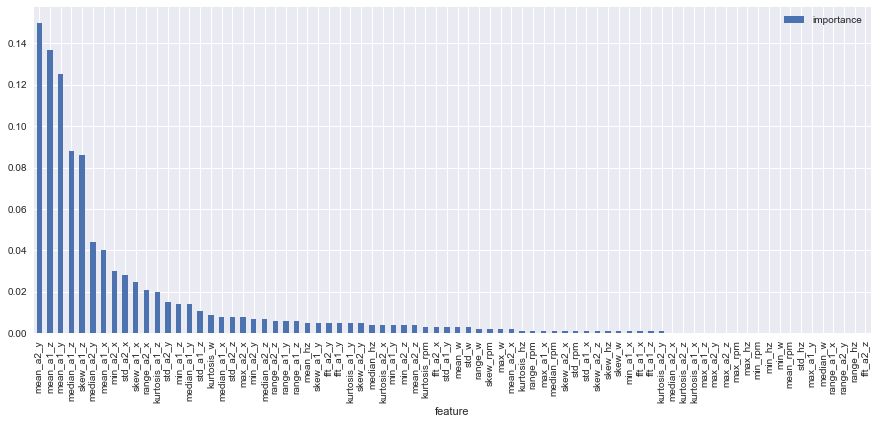

In [20]:
# To check the importance of all feature of Random Forest calssification model
importances = pd.DataFrame({'feature': X_train.columns, 'importance': np.round(rf.feature_importances_, 3)})
importances1 = importances.sort_values('importance', ascending=False).set_index('feature')
importances1.plot(kind='bar', figsize=(15,6))

In [21]:
# To check the score using Support Vector classification model 

svc = SVC(probability=True)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
accuracy_svc = round(accuracy_score(y_test, y_pred_svc) * 100, 2)
print(f"The accuracy of SVC Model is : ", str(accuracy_svc) + '%')
print(f"The Cross Validation Report : ", '\n', (classification_report(y_test, y_pred_svc)))
print(f"The confusion matrix : ", '\n', confusion_matrix(y_test, y_pred_svc))
scores_svc = cross_val_score(svc, X_train, y_train, cv=10, scoring = "accuracy")
print(f"The Cross validation score of SVC Model : ", '\n', scores_svc)
print(f"The Mean of SVC Model : ", scores_svc.mean())
print(f"The Standard Deviation of SVC Model : ", scores_svc.std())

The accuracy of SVC Model is :  82.61%
The Cross Validation Report :  
               precision    recall  f1-score   support

           0       0.83      1.00      0.90        19
           1       0.00      0.00      0.00         4

    accuracy                           0.83        23
   macro avg       0.41      0.50      0.45        23
weighted avg       0.68      0.83      0.75        23

The confusion matrix :  
 [[19  0]
 [ 4  0]]


C:\Users\Sadhana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sadhana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sadhana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sadhana\anaconda3\lib\site-packages\skle

The Cross validation score of SVC Model :  
 [1.         0.88888889 0.88888889 0.88888889 0.88888889 0.88888889
 0.88888889 0.88888889 0.88888889 1.        ]
The Mean of SVC Model :  0.9111111111111111
The Standard Deviation of SVC Model :  0.04444444444444447


In [22]:
# To check the score using KNN classification model 

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
accuracy_knn = round(accuracy_score(y_test, y_pred_knn) * 100, 2)
print(f'The accuracy of KNN Model is : ', str(accuracy_knn) + '%')
print('The Cross Validation Report : ','\n', (classification_report(y_test, y_pred_knn)))
print(f"The confusion matrix : ", '\n', confusion_matrix(y_test, y_pred_knn))
scores_knn = cross_val_score(knn, X_train, y_train, cv=10, scoring = "accuracy")
print(f"The Cross validation score of KNN Model :", '\n', scores_knn)
print(f"The Mean of KNN Model :", scores_knn.mean())
print(f"The Standard Deviation of KNN Model :", scores_knn.std())

The accuracy of KNN Model is :  78.26%
The Cross Validation Report :  
               precision    recall  f1-score   support

           0       0.82      0.95      0.88        19
           1       0.00      0.00      0.00         4

    accuracy                           0.78        23
   macro avg       0.41      0.47      0.44        23
weighted avg       0.68      0.78      0.73        23

The confusion matrix :  
 [[18  1]
 [ 4  0]]
The Cross validation score of KNN Model : 
 [1.         0.77777778 0.88888889 0.77777778 0.77777778 0.77777778
 0.88888889 0.88888889 0.77777778 1.        ]
The Mean of KNN Model : 0.8555555555555554
The Standard Deviation of KNN Model : 0.08678055195451836


C:\Users\Sadhana\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
